In [1]:
import torch
from control_stork.optimizers import SMORMS3
from control_stork.generators import StandardGenerator
from control_stork.nodes import CellGroup, LIFGroup, FastLIFGroup, NoisyFastLIFGroup
from control_stork.nodes import (
    InputGroup,
    ReadoutGroup,
    FastReadoutGroup,
    DirectReadoutGroup,
    TimeAverageReadoutGroup,
)
from control_stork.connections import Connection, BottleneckLinearConnection
from control_stork.models import RecurrentSpikingModel
from control_stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    KaimingNormalInitializer,
    DistInitializer,
    AverageInitializer,
)
from control_stork.monitors import (
    MeanVarianceMonitor,
    SpikeMonitor,
    SpikeCountMonitor,
    StateMonitor,
    PopulationFiringRateMonitor,
    PopulationSpikeCountMonitor,
    PlotStateMonitor,
)
from control_stork.loss_stacks import MaxOverTimeCrossEntropy, SumOverTimeCrossEntropy, LossStack
from control_stork.regularizers import LowerBoundL2, UpperBoundL2
from control_stork.activations import SigmoidSpike
from control_stork.layers import Layer
from control_stork.plotting import plot_traces, plot_spikes
from control_stork.extratypes import *

import torchvision
from torchvision import datasets, transforms

import time
import math
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

In [2]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device", device)

# torch.autograd.set_detect_anomaly(True)

using device cuda


In [3]:
# to reset the random seed

def reset_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

reset_seed()

In [4]:
# define some parameters
batch_size_train = 512
batch_size_test = 512

# make the datasets
train_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1, 784))])
)
test_dataset = torchvision.datasets.MNIST('./files/', train=False, download=True,
                            transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1, 784))])
)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=batch_size_test, shuffle=True)

In [5]:
# make a new neuron type
class FastIFGroup(CellGroup):
    def __init__(
        self,
        shape,
        threshold=1.0,
        reset='sub',
        diff_reset=False,
        learn_timescales=False,
        clamp_mem=False,
        activation=SigmoidSpike,
        dropout_p=0.0,
        stateful=False,
        name="IFGroup",
        regularizers=None,
        **kwargs
    ):
        """
        Integrate-and-Fire neuron.
        It has two state variables that are scalars and are updated at every time step:
        `mem` is for the membrane potential, and `out` is 0/1 depending on
        whether the neuron produces a spike.

        Args:
            :param shape: The number of units in this group
            :type shape: int or tuple of int
            :param threshold: The threshold potential in V, defaults to 1.0
            :type threshold: float
            :param reset: The reset mode, either 'sub' for subtractive or 'set' for setting the membrane potential to 0,
                            defaults to 'sub'
            :type reset: str
            :param diff_reset: Whether or not to differentiate through the reset term, defaults to False
            :type diff_reset: bool
            :param learn_timescales: Whether to learn the membrane and synaptic time constants, defaults to False
            :type learn_timescales: bool
            :param activation: The surrogate derivative enabled activation function, defaults to stork.activations.SuperSpike
            :type activation: stork.activations
            :param dropout_p: probability that some elements of the input will be zeroed, defaults to 0.0
            :type dropout_p: float
            :param stateful: Whether or not to reset the state of the neurons between mini-batches, defaults to False
            :type stateful: bool
            :param regularizers: List of regularizers
        """

        super().__init__(
            shape,
            dropout_p=dropout_p,
            stateful=stateful,
            name=name,
            regularizers=regularizers,
            **kwargs
        )
        self.threshold = threshold
        self.reset = reset.lower()
        if self.reset not in ["sub", "set"]:
            raise ValueError("reset must be either 'sub' or 'set'")
        self.reset_mem = self.subtractive_reset if self.reset == "sub" else self.multiplicative_reset
        self.activation = activation
        self.spk_nl = self.activation.apply
        self.diff_reset = diff_reset
        self.learn_timescales = learn_timescales
        self.clamp_mem = clamp_mem
        self.mem = None

    def configure(self, time_step, device, dtype):

        super().configure(time_step, device, dtype)

    def reset_state(self, batch_size: int = 1):
        super().reset_state(batch_size)
        self.mem = self.get_state_tensor("mem", state=self.mem)
        self.out = self.states["out"] = torch.zeros(
            self.int_shape, device=self.device, dtype=self.dtype
        )
        
    def feed_data(self, data: torch.Tensor) -> None:
        self.local_data = data.reshape((data.shape[:2] + self.shape)).to(self.device)
        self.counter = 0

    def multiplicative_reset(self, mem, rst):

        return mem * (1.0 - rst)
    
    def subtractive_reset(self, mem, rst):

        return mem - self.threshold * rst

    def get_spike_and_reset(self, mem):
        mthr = mem - self.threshold

        out = self.spk_nl(mthr)
        if self.diff_reset:
            rst = out
        else:
            # if differentiation should not go through reset term, detach it from the computational graph
            rst = out.detach()

        return out, rst

    def forward(self):

        self.input = self.local_data[:,self.counter]
        self.counter += 1

        # membrane dynamics
        new_mem = self.mem + self.time_step * self.input
        # spike
        new_out, rst = self.get_spike_and_reset(self.mem)
        # reset
        new_mem = self.reset_mem(new_mem, rst)

        # Clamp membrane potential
        if self.clamp_mem:
            new_mem = torch.clamp(new_mem, max=1.01)

        self.out = self.states["out"] = new_out
        self.mem = self.states["mem"] = new_mem


In [7]:
class NoisyFastLIFGroup(FastLIFGroup):
    def __init__(
        self,
        shape,
        tau_mem=10e-3,
        tau_syn=5e-3,
        threshold=1.0,
        reset="sub",
        diff_reset=False,
        learn_timescales=False,
        clamp_mem=False,
        activation=SigmoidSpike,
        dropout_p=0.0,
        stateful=False,
        name="NoisyFastLIFGroup",
        regularizers=None,
        noise_std: float = 0.1,
        **kwargs
    ):
        """
        Leaky Integrate-and-Fire neuron with decaying synaptic input current.
        It has three state variables that are scalars and are updated at every time step:
        `mem` is for the membrane potential, `syn` is for the synaptic input current, and `out` is 0/1 depending on
        whether the neuron produces a spike.

        Args:
            :param shape: The number of units in this group
            :type shape: int or tuple of int
            :param tau_mem: The membrane time constant in s, defaults to 10e-3
            :type tau_mem: float
            :param tau_syn: The synaptic time constant in s, defaults to 5e-3
            :type tau_syn: float
            :param threshold: The threshold potential in V, defaults to 1.0
            :type threshold: float
            :param reset: The reset mode, either 'sub' for subtractive or 'set' for setting the membrane potential to the reset value, defaults to 'sub'
            :type reset: str
            :param diff_reset: Whether or not to differentiate through the reset term, defaults to False
            :type diff_reset: bool
            :param learn_timescales: Whether to learn the membrane and synaptic time constants, defaults to False
            :type learn_timescales: bool
            :param activation: The surrogate derivative enabled activation function, defaults to stork.activations.SuperSpike
            :type activation: stork.activations
            :param dropout_p: probability that some elements of the input will be zeroed, defaults to 0.0
            :type dropout_p: float
            :param stateful: Whether or not to reset the state of the neurons between mini-batches, defaults to False
            :type stateful: bool
            :param regularizers: List of regularizers
            :param noise_std: Standard deviation of the noise added to the threshold
            :type noise_std: float
        """
        super().__init__(
            shape,
            tau_mem,
            tau_syn,
            threshold,
            reset,
            diff_reset,
            learn_timescales,
            clamp_mem,
            activation,
            dropout_p,
            stateful,
            name,
            regularizers,
            **kwargs
        )

        self.r = None
        self.noise = False
        self.sigma = 1.0
    
    def set_noise_flag(self, noise: bool = True, sigma=1.0) -> None:
        self.noise = noise
        self.sigma = sigma

    def get_noise_flag(self):
        return self.noise

    def get_noise(self):
        return self.r

    def set_noise(self, r):
        self.r = r

    def sample_noise(self):
        return self.sigma * torch.randn_like(self.out)

    def reset_noise(self):
        self.r = self.sample_noise()

    def reset_state(self, batch_size: int = 1) -> None:
        super().reset_state(batch_size)
        if self.noise:
            self.reset_noise()
        else:
            self.set_noise(0.0)

    def forward(self) -> None:
        # synaptic & membrane dynamics
        new_syn = self.dcy_syn * self.syn + self.input
        new_mem = self.dcy_mem * self.mem + self.scl_mem * new_syn

        # spike
        new_out, rst = self.get_spike_and_reset(new_mem)
        # reset
        new_mem = self.reset_mem(new_mem, rst)

        # add noise
        if self.noise:
            new_mem += self.r * self.time_step

        # Clamp membrane potential
        if self.clamp_mem:
            new_mem = torch.clamp(new_mem, max=1.01)

        self.out = self.states["out"] = new_out
        self.mem = self.states["mem"] = new_mem
        self.syn = self.states["syn"] = new_syn



# define another neuron type with noise on the membrane potential
class NoisyFastReadoutGroup(FastReadoutGroup):
    def __init__(
        self,
        shape: Union[int, Iterable],
        tau_mem: Union[float, torch.Tensor] = 10e-3,
        tau_syn: Union[float, torch.Tensor] = 5e-3,
        weight_scale: float = 1.0,
        initial_state: float = -1e-3,
        stateful: bool = False,  # ? what is this good for? Why is it not True?
        name: Optional[str] = None,
        store_sequences: Optional[Iterable] = ["out"],
        **kwargs
    ) -> None:
        super().__init__(
            shape=shape,
            tau_mem=tau_mem,
            tau_syn=tau_syn,
            weight_scale=weight_scale,
            initial_state=initial_state,
            stateful=stateful,
            name="Noisy Fast Readout" if name is None else name,
            store_sequences=store_sequences,
            **kwargs
        )
        self.tau_mem = tau_mem
        self.tau_syn = tau_syn
        self.store_output_seq = True
        self.initial_state = initial_state  # ? why is this not 0?
        self.weight_scale = weight_scale  # ? what is this good for?
        self.out = None
        self.syn = None
        self.r = None
        self.noise = False
        self.sigma = 1.0

    def configure(self, time_step, device, dtype) -> None:
        super().configure(time_step, device, dtype)

        # TODO: change the time constant handling and add learning possibility
        self.dcy_mem = float(torch.exp(-time_step / torch.tensor(self.tau_mem)))
        self.scl_mem = 1.0 - self.dcy_mem
        self.dcy_syn = float(torch.exp(-time_step / torch.tensor(self.tau_syn)))
        self.scl_syn = (1.0 - self.dcy_syn) * self.weight_scale

    def set_noise_flag(self, noise: bool = True, sigma=1.0) -> None:
        self.noise = noise
        self.sigma = sigma

    def get_noise_flag(self):
        return self.noise

    def get_noise(self):
        return self.r

    def set_noise(self, r):
        self.r = r

    def sample_noise(self):
        return self.sigma * torch.randn_like(self.out)

    def reset_noise(self):
        self.r = self.sample_noise()

    def reset_state(self, batch_size: int = 1) -> None:
        super().reset_state(batch_size)
        self.out = self.get_state_tensor("out", state=self.out, init=self.initial_state)
        self.syn = self.get_state_tensor("syn", state=self.syn)
        if self.noise:
            self.reset_noise()
        else:
            self.set_noise(0.0)

    def forward(self) -> None:
        # synaptic & membrane dynamics
        new_syn = self.dcy_syn * self.syn + self.input
        new_mem = self.dcy_mem * self.out + self.scl_mem * new_syn

        # add noise
        if self.noise:
            new_mem += self.r * self.time_step

        self.out = self.states["out"] = new_mem
        self.syn = self.states["syn"] = new_syn

In [6]:
reset_seed()

# model size
n_hidden = 1
input_dim = 784
hidden_dim = 256
output_dim = 10

# neuron parameters
neuron_class = FastLIFGroup  # NoisyFastLIFGroup  # FastLIFGroup
neuron_kwargs = dict(
    activation=SigmoidSpike,
    tau_mem_out=0.02,
    tau_syn_out=0.01,
    store_sequences = ["out"],
)  #'noise_std': 0.05}
connection_class = Connection
recurrent = True
connection_kwargs = dict(
    bias=True
)

# readout parameters
readout_class = FastReadoutGroup
readout_kwargs = dict(
    n_readouts=1,
    tau_mem_out=0.02,
    tau_syn_out=0.01,
    store_sequences = ["out"],
)

# initialize weights
sigma_u = 1.0
nu = 10
time_step = 2e-3

# optimizer parameters
lr = 5e-3
optimizer_class = SMORMS3  # torch.optim.Adam # SMORMS3

# regularization parameters
lowerBoundL2Strength = 0.0
lowerBoundL2Threshold = 0.0
upperBoundL2Strength = 0.0  # 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# make the model
rsm = RecurrentSpikingModel(
    device=device,
)

# make the initializers
initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u,
    nu=nu,
    time_step=time_step,
)

# make the regularizers
regs = []
if lowerBoundL2Strength > 0:
    regLB = LowerBoundL2(
        lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
    )
    regs.append(regLB)
if upperBoundL2Strength > 0:
    regUB = UpperBoundL2(upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1)
    regs.append(regUB)

# make the groups and connections
input_group = prev = rsm.add_group(
    FastIFGroup(
    # InputGroup(
        input_dim, 
        name="Input IF Group",
        **neuron_kwargs,
    ))
for i in range(n_hidden):
    new = Layer(
        name=f"Hidden Cell Group {i+1}",
        model=rsm,
        size=hidden_dim,
        input_group=prev,
        recurrent=recurrent,
        regs=regs,
        connection_class=connection_class,
        neuron_class=neuron_class,
        neuron_kwargs=neuron_kwargs,
        connection_kwargs=connection_kwargs,
    )
    initializer.initialize(new)
    prev = new.output_group

output_layer = new = Layer(
    name="Readout Pool Layer",
    model=rsm,
    size=output_dim * readout_kwargs["n_readouts"],
    input_group=prev,
    recurrent=False,
    regs=regs,
    connection_class=connection_class,
    neuron_class=readout_class,
    neuron_kwargs=readout_kwargs,
    connection_kwargs=connection_kwargs,
)
initializer.initialize(new)
prev = new.output_group

# make the monitors
for i in range(n_hidden):
    # rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[1+i], per_example=True))
    rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[1 + i], avg=True))
    rsm.add_monitor(
        PlotStateMonitor(
            rsm.groups[1 + i],
            "out",
            plot_fn=plot_spikes,
            title=f"Hidden Cell Group {i+1}",
        )
    )
    rsm.add_monitor(
        PlotStateMonitor(
            rsm.groups[1 + i],
            "mem",
            plot_fn=plot_traces,
            title=f"Hidden Cell Group {i+1}",
        )
    )
rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[0], avg=True))
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[0],
        "out",
        plot_fn=plot_spikes,
        title=f"Hidden Cell Group {0}",
    )
)
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[0], "out", plot_fn=plot_traces, title="Input Units"
    )
)
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[-1], "out", plot_fn=plot_traces, title="Readout Group"
    )
)

loss_stack = MaxOverTimeCrossEntropy()
generator = StandardGenerator()
generator.configure(
    batch_size_train, 100, 784, time_step, device, torch.float32)

rsm.configure(
    input_group,
    prev,
    optimizer=optimizer_class,
    optimizer_kwargs={"lr": lr},
    time_step=time_step,
    generator=generator,
    loss_stack=loss_stack,
)

rsm.summary()


# Model summary

## Groups
Input IF Group, (784,)
Hidden Cell Group 1, (256,)
Readout Pool Layer, (10,)

## Connections
Connection(
  (src): FastIFGroup() Input IF Group
  (dst): FastLIFGroup() Hidden Cell Group 1
  (op): Linear(in_features=784, out_features=256, bias=True)
) 
Connection(
  (src): FastLIFGroup() Hidden Cell Group 1
  (dst): FastLIFGroup() Hidden Cell Group 1
  (op): Linear(in_features=256, out_features=256, bias=True)
) 
Connection(
  (src): FastLIFGroup() Hidden Cell Group 1
  (dst): FastReadoutGroup() Readout Pool Layer
  (op): Linear(in_features=256, out_features=10, bias=True)
) 

## Trainable Parameters
Total number of trainable parameters: 269322
Number of parameter objects: 6


In [7]:
# get one batch of training images
data, target = next(iter(train_loader))
data = data.to(device)
target = target.to(device)
x = data.view(batch_size_train, 1, 784)

# reset the network
N = data.shape[0]
rsm.reset_state(N)

# run the network
for i in range(100):
    y = rsm(x / rsm.time_step)

# get the output
mem_out = torch.stack(rsm.output_group.stored_sequences_['out']).transpose(0, 1)
spk_inp = torch.stack(rsm.input_group.stored_sequences_['out']).transpose(0, 1)

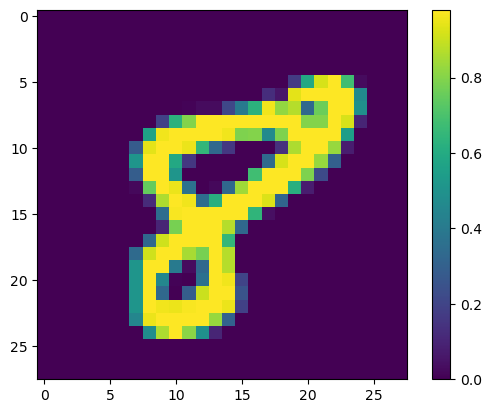

In [8]:
# take a look at the input
avg = torch.mean(spk_inp, dim=1)
plt.imshow(avg[0].detach().cpu().reshape(28, 28).numpy())
plt.colorbar()
plt.show()

In [6]:
# define a surrogate gradient training function
def train_epoch_sur(model, train_loader, repeat_input, device):
    """Train the model on the training set for a single epoch with surrogate gradients.

    Args:
        model: The model to evaluate.
        train_loader: The trianig set loader.
        repeat_input: The number of times to repeat the input.
        device: The device to use.

    Returns:
        The average loss and accuracy.
    """

    model.train()
    losses = []
    accs = []
    batch = 0

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        N = data.shape[0]

        model.reset_state(N)

        for i in range(repeat_input):
            y = model(data / model.time_step)

        loss = model.loss_stack.compute_loss(y, target)
        acc = model.loss_stack.get_acc(y, target)

        model.optimizer_instance.zero_grad()
        loss.backward()
        model.optimizer_instance.step()

        losses.append(loss.item())
        accs.append(acc.item())
        batch += 1

    avg_loss = torch.mean(torch.tensor(losses))
    avg_acc = torch.mean(torch.tensor(accs))

    return avg_loss, avg_acc


# define an evaluation function
def evaluate(model, test_loader, repeat_input, device):
    """Evaluate the model on the test set.

    Args:
        model: The model to evaluate.
        test_loader: The test set loader.
        repeat_input: The number of times to repeat the input.
        device: The device to use.

    Returns:
        The average loss and accuracy.
    """

    model.eval()
    losses = []
    accs = []
    batch = 0

    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        N = data.shape[0]

        model.reset_state(N)

        for i in range(repeat_input):
            y = model(data / model.time_step, record=True)

        loss = model.loss_stack.compute_loss(y, target)
        acc = model.loss_stack.get_acc(y, target)

        losses.append(torch.mean(loss).item())
        accs.append(acc.item())
        batch += 1

    avg_loss = torch.mean(torch.tensor(losses))
    avg_acc = torch.mean(torch.tensor(accs))

    return avg_loss, avg_acc

In [10]:
# run some surrogate gradient training

reset_seed()

epochs = 20
repeat_input = 40

losses = []
accs = []
losses_eval = []
accs_eval = []

for e in range(epochs):

    loss, acc = train_epoch_sur(rsm, train_loader, repeat_input, device)

    losses.append(loss)
    accs.append(acc)

    eloss, eacc = evaluate(rsm, test_loader, repeat_input, device)

    losses_eval.append(eloss)
    accs_eval.append(eacc)

    print(
        f"Epoch {e+1}/{epochs} - Train Loss: {loss:.5f} - Train ACC: {acc:.5f} - Eval Loss: {eloss:.5f} - Eval ACC: {eacc:.5f}"
    )

Epoch 1/20 - Train Loss: 1.66337 - Train ACC: 0.47554 - Eval Loss: 0.92128 - Eval ACC: 0.72223
Epoch 2/20 - Train Loss: 0.62562 - Train ACC: 0.80916 - Eval Loss: 0.49324 - Eval ACC: 0.85896
Epoch 3/20 - Train Loss: 0.32276 - Train ACC: 0.90922 - Eval Loss: 0.26284 - Eval ACC: 0.92169
Epoch 4/20 - Train Loss: 0.23406 - Train ACC: 0.93295 - Eval Loss: 0.22549 - Eval ACC: 0.93560
Epoch 5/20 - Train Loss: 0.19510 - Train ACC: 0.94296 - Eval Loss: 0.20853 - Eval ACC: 0.93911
Epoch 6/20 - Train Loss: 0.16836 - Train ACC: 0.95021 - Eval Loss: 0.19266 - Eval ACC: 0.94204
Epoch 7/20 - Train Loss: 0.14679 - Train ACC: 0.95676 - Eval Loss: 0.18247 - Eval ACC: 0.94500
Epoch 8/20 - Train Loss: 0.12923 - Train ACC: 0.96217 - Eval Loss: 0.16883 - Eval ACC: 0.95084
Epoch 9/20 - Train Loss: 0.11702 - Train ACC: 0.96616 - Eval Loss: 0.16542 - Eval ACC: 0.95047
Epoch 10/20 - Train Loss: 0.10679 - Train ACC: 0.96878 - Eval Loss: 0.15776 - Eval ACC: 0.95392
Epoch 11/20 - Train Loss: 0.09771 - Train ACC: 0.

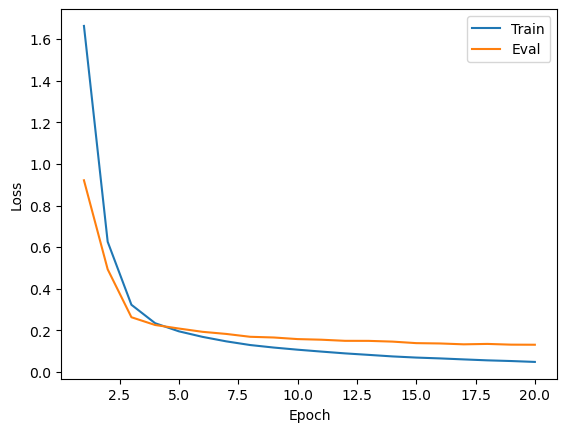

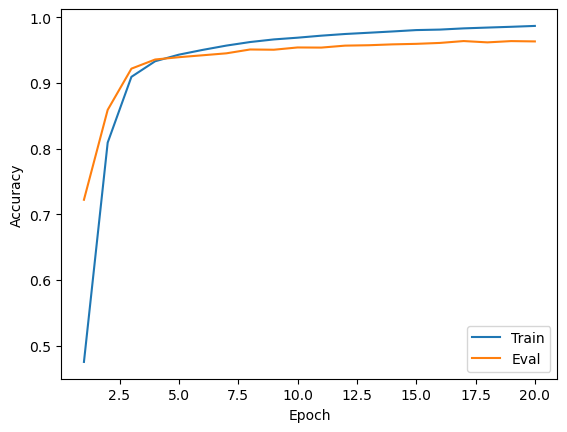

In [11]:
# plot the results
x_axis = np.arange(1, epochs+1)
plt.plot(x_axis, losses, label="Train")
plt.plot(x_axis, losses_eval, label="Eval")
# plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(x_axis, accs, label="Train")
plt.plot(x_axis, accs_eval, label="Eval")
# plt.yscale("log")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# save the results
np.save("mnist_accs_sur.npy", np.array(accs))
np.save("mnist_losses_sur.npy", np.array(losses))
np.save("mnist_accs_eval_sur.npy", np.array(accs_eval))
np.save("mnist_losses_eval_sur.npy", np.array(losses_eval))

PopulationSpikeCountMonitor on Hidden Cell Group 1
firing rate: 196.11458480358124
spike density: 0.3922291696071625
PlotStateMonitor on Hidden Cell Group 1 for out
PlotStateMonitor on Hidden Cell Group 1 for mem
PopulationSpikeCountMonitor on Input IF Group
firing rate: 63.240572810173035
spike density: 0.12648114562034607
PlotStateMonitor on Input IF Group for out
PlotStateMonitor on Readout Pool Layer for out


/tmp/ipykernel_2100270/2612496646.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  v.show()


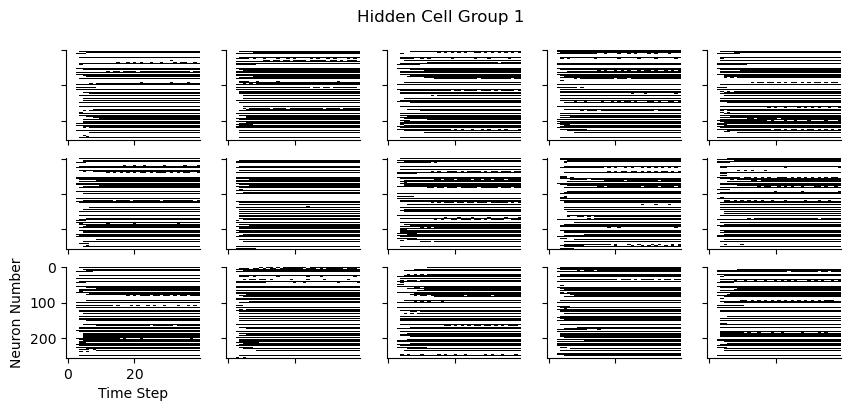

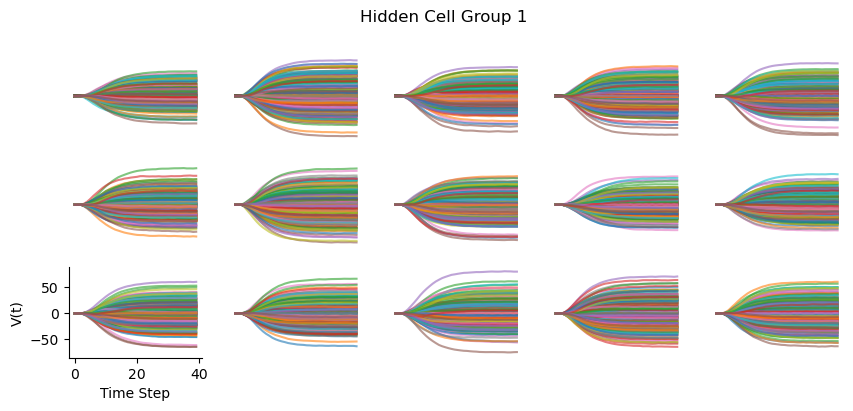

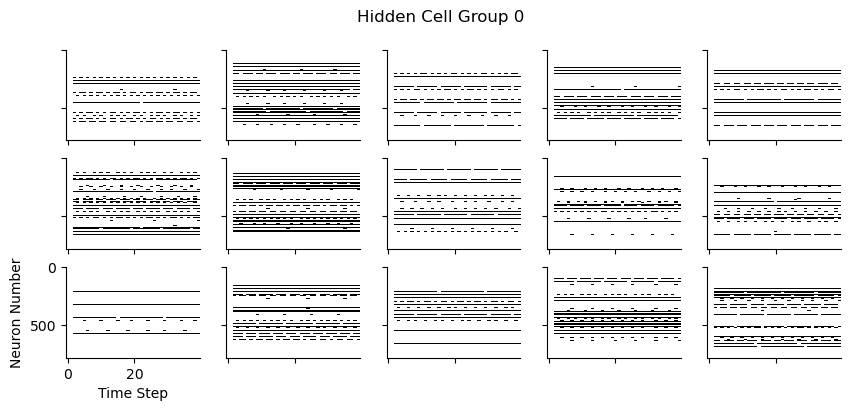

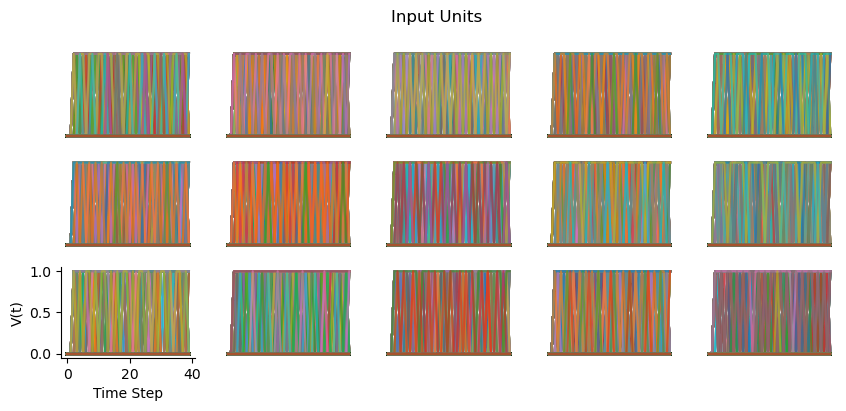

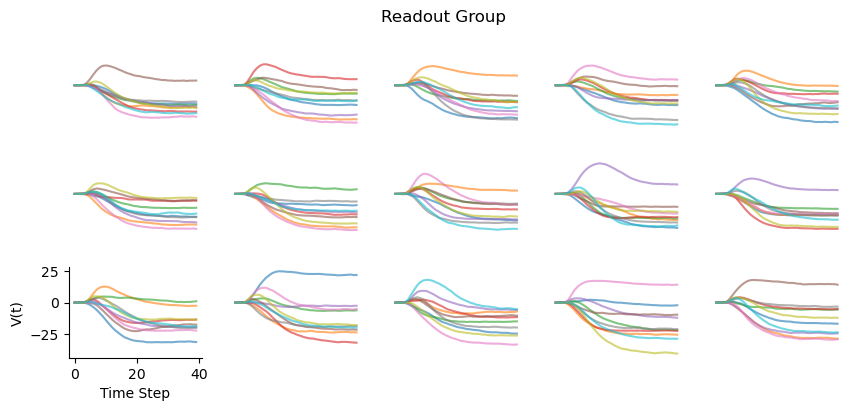

In [12]:
data = rsm.get_monitor_data()
for k, v in data.items():
    print(k)
    if isinstance(v, matplotlib.figure.Figure):
        v.show()
    elif v is None:
        print("None")
    elif "PopulationSpikeCountMonitor" in k:
        print("firing rate:", v.item() / (time_step))
        print("spike density:", v.item())
    else:
        print(v)

In [66]:
reset_seed()

# model size
n_hidden = 0
input_dim = 784
hidden_dim = 256
output_dim = 10

# neuron parameters
neuron_class = NoisyFastLIFGroup  # FastLIFGroup
neuron_kwargs = dict(
    activation=SigmoidSpike,
    tau_mem_out=0.02,
    tau_syn_out=0.01,
    store_sequences = ["out"],
)  #'noise_std': 0.05}
connection_class = Connection
recurrent = True
connection_kwargs = dict(
    bias=False
)

# readout parameters
readout_class = NoisyFastReadoutGroup
readout_kwargs = dict(
    n_readouts=1,
    tau_mem_out=0.02,
    tau_syn_out=0.01,
    store_sequences = ["out"],
)

# initialize weights
sigma_u = 1.0
nu = 10
time_step = 2e-3

# optimizer parameters
lr = 5e-3
optimizer_class = SMORMS3  # torch.optim.Adam # SMORMS3

# regularization parameters
lowerBoundL2Strength = 0.0
lowerBoundL2Threshold = 0.0
upperBoundL2Strength = 0.0  # 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# make the model
rsm = RecurrentSpikingModel(
    device=device,
)

# make the initializers
initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u,
    nu=nu,
    time_step=time_step,
)

# make the regularizers
regs = []
if lowerBoundL2Strength > 0:
    regLB = LowerBoundL2(
        lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
    )
    regs.append(regLB)
if upperBoundL2Strength > 0:
    regUB = UpperBoundL2(upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1)
    regs.append(regUB)

# make the groups and connections
input_group = prev = rsm.add_group(
    FastIFGroup(
    # InputGroup(
        input_dim, 
        name="Input IF Group",
        **neuron_kwargs,
    ))
for i in range(n_hidden):
    new = Layer(
        name=f"Hidden Cell Group {i+1}",
        model=rsm,
        size=hidden_dim,
        input_group=prev,
        recurrent=recurrent,
        regs=regs,
        connection_class=connection_class,
        neuron_class=neuron_class,
        neuron_kwargs=neuron_kwargs,
        connection_kwargs=connection_kwargs,
    )
    initializer.initialize(new)
    prev = new.output_group

output_layer = new = Layer(
    name="Readout Pool Layer",
    model=rsm,
    size=output_dim * readout_kwargs["n_readouts"],
    input_group=prev,
    recurrent=False,
    regs=regs,
    connection_class=connection_class,
    neuron_class=readout_class,
    neuron_kwargs=readout_kwargs,
    connection_kwargs=connection_kwargs,
)
initializer.initialize(new)
prev = new.output_group

# make the monitors
for i in range(n_hidden):
    # rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[1+i], per_example=True))
    rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[1 + i], avg=True))
    rsm.add_monitor(
        PlotStateMonitor(
            rsm.groups[1 + i],
            "out",
            plot_fn=plot_spikes,
            title=f"Hidden Cell Group {i+1}",
        )
    )
    rsm.add_monitor(
        PlotStateMonitor(
            rsm.groups[1 + i],
            "mem",
            plot_fn=plot_traces,
            title=f"Hidden Cell Group {i+1}",
        )
    )
    # rsm.add_monitor(MeanVarianceMonitor(rsm.groups[1 + i], "out", dim=(0, 1)))
rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[0], avg=True))
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[0],
        "out",
        plot_fn=plot_spikes,
        title=f"Hidden Cell Group {0}",
    )
)
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[0], "out", plot_fn=plot_traces, title="Input Units"
    )
)
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[-1], "out", plot_fn=plot_traces, title="Readout Group"
    )
)

loss_stack = MaxOverTimeCrossEntropy(
    neg_log_likelihood_loss = torch.nn.NLLLoss(reduction='none')
)
generator = StandardGenerator()
generator.configure(
    batch_size_train, 100, 784, time_step, device, torch.float32)

rsm.configure(
    input_group,
    prev,
    optimizer=optimizer_class,
    optimizer_kwargs={"lr": lr},
    time_step=time_step,
    generator=generator,
    loss_stack=loss_stack,
)

rsm.summary()


# Model summary

## Groups
Input IF Group, (784,)
Readout Pool Layer, (10,)

## Connections
Connection(
  (src): FastIFGroup() Input IF Group
  (dst): NoisyFastReadoutGroup() Readout Pool Layer
  (op): Linear(in_features=784, out_features=10, bias=False)
) 

## Trainable Parameters
Total number of trainable parameters: 7840
Number of parameter objects: 1


In [8]:
def normalize_noise(noise):
    return torch.sqrt(torch.tensor(noise.shape[1])) * noise / torch.norm(noise, dim=1, keepdim=True)

In [9]:
# define a noise pertubation training function
def train_epoch_np(model, train_loader, repeat_input, sigma, learning_rate, device):
    """Train the model on the training set for a single epoch with surrogate gradients.

    Args:
        model: The model to evaluate.
        train_loader: The training set loader.81112
        repeat_input: The number of times to repeat the input.
        sigma: The noise level.
        learning_rate: The learning rate.
        device: The device to use.

    Returns:
        The average loss and accuracy.
    """

    model.train()
    losses = []
    accs = []
    batch = 0

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        N = data.shape[0]

        # do pass without noise
        for g in model.groups[1:]:
            g.set_noise_flag(False)
        model.reset_state(N)

        for i in range(repeat_input):
            y_no_noise = model(data / model.time_step)

        loss_no_noise = model.loss_stack.compute_loss(y_no_noise, target)
        acc_no_noise = model.loss_stack.get_acc(y_no_noise, target)

        losses.append(torch.mean(loss_no_noise).item())
        accs.append(acc_no_noise.item())

        # do pass with noise
        for g in model.groups[1:]:
            g.set_noise_flag(True, sigma=sigma)
        model.reset_state(N)

        for i in range(repeat_input):
            y_w_noise = model(data / model.time_step)

        loss_w_noise = model.loss_stack.compute_loss(y_w_noise, target)

        delta_loss = loss_w_noise - loss_no_noise

        for c in model.connections:
            # Averaging over batch, computing traditional NP update
            norm_noise = normalize_noise(c.dst.get_noise())
            delta_w = (
                -(1 / N) 
                * (delta_loss[:, None] * norm_noise).transpose(0, 1)
                @ torch.mean(c.src.get_out_sequence(), axis=1)
            )

            c.op.weight.data += learning_rate * delta_w
            if c.op.bias is not None:
                delta_b = - (delta_loss[:, None] * norm_noise).mean(axis=0)
                c.op.bias.data += learning_rate * delta_b
            
        batch += 1

    for g in model.groups[1:]:
        g.set_noise_flag(False)

    avg_loss = torch.mean(torch.tensor(losses))
    avg_acc = torch.mean(torch.tensor(accs))

    return avg_loss, avg_acc


# define a noise pertubation training function with optimizer
def train_epoch_np_w_optimizer(model, train_loader, repeat_input, sigma, device):
    """Train the model on the training set for a single epoch with surrogate gradients.

    Args:
        model: The model to evaluate.
        train_loader: The training set loader.
        repeat_input: The number of times to repeat the input.
        sigma: The noise level.
        device: The device to use.

    Returns:
        The average loss and accuracy.
    """

    model.train()
    losses = []
    accs = []
    batch = 0

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        N = data.shape[0]

        # do pass without noise
        for g in model.groups[1:]:
            g.set_noise_flag(False)
        model.reset_state(N)

        for i in range(repeat_input):
            y_no_noise = model(data / model.time_step)

        loss_no_noise = model.loss_stack.compute_loss(y_no_noise, target)
        acc_no_noise = model.loss_stack.get_acc(y_no_noise, target)

        losses.append(torch.mean(loss_no_noise).item())
        accs.append(acc_no_noise.item())

        # do pass with noise
        for g in model.groups[1:]:
            g.set_noise_flag(True, sigma=sigma)
        model.reset_state(N)

        for i in range(repeat_input):
            y_w_noise = model(data / model.time_step)

        loss_w_noise = model.loss_stack.compute_loss(y_w_noise, target)

        delta_loss = loss_w_noise - loss_no_noise

        model.optimizer_instance.zero_grad()
        for c in model.connections:
            # Averaging over batch, computing traditional NP update
            norm_noise = normalize_noise(c.dst.get_noise())
            grad = (
                (1 / N)
                * (delta_loss[:, None] * norm_noise).transpose(0, 1)
                @ torch.mean(c.src.get_out_sequence(), axis=1)
            )
            c.op.weight.grad = grad
            if c.op.bias is not None:
                grad = (delta_loss[:, None] * norm_noise).mean(axis=0)
                c.op.bias.grad = grad
                
        model.optimizer_instance.step()

        batch += 1

    for g in model.groups[1:]:
        g.set_noise_flag(False)

    avg_loss = torch.mean(torch.tensor(losses))
    avg_acc = torch.mean(torch.tensor(accs))

    return avg_loss, avg_acc

In [69]:
# run some noise pertubation training

reset_seed()

epochs = 20
repeat_input = 40
learning_rate = 0.5
sigma = 1.0

losses = []
accs = []
losses_eval = []
accs_eval = []

with torch.no_grad():

    for e in range(epochs):

        loss, acc = train_epoch_np_w_optimizer(rsm, train_loader, repeat_input, sigma, device)
        #loss, acc = train_epoch_np(rsm, train_loader, repeat_input, sigma, learning_rate, device)

        losses.append(loss)
        accs.append(acc)

        eloss, eacc = evaluate(rsm, test_loader, repeat_input, device)

        losses_eval.append(eloss)
        accs_eval.append(eacc)

        print(
            f"Epoch {e+1}/{epochs} - Train Loss: {loss:.5f} - Train ACC: {acc:.5f} - Eval Loss: {eloss:.5f} - Eval ACC: {eacc:.5f}"
        )

Epoch 1/20 - Train Loss: 2.07295 - Train ACC: 0.50888 - Eval Loss: 1.08599 - Eval ACC: 0.71689
Epoch 2/20 - Train Loss: 0.93918 - Train ACC: 0.77411 - Eval Loss: 0.81997 - Eval ACC: 0.81130
Epoch 3/20 - Train Loss: 0.76267 - Train ACC: 0.82258 - Eval Loss: 0.68172 - Eval ACC: 0.84251
Epoch 4/20 - Train Loss: 0.67351 - Train ACC: 0.84036 - Eval Loss: 0.59414 - Eval ACC: 0.85754
Epoch 5/20 - Train Loss: 0.62495 - Train ACC: 0.85180 - Eval Loss: 0.62108 - Eval ACC: 0.85493
Epoch 6/20 - Train Loss: 0.59045 - Train ACC: 0.86111 - Eval Loss: 0.52900 - Eval ACC: 0.87835
Epoch 7/20 - Train Loss: 0.56392 - Train ACC: 0.86760 - Eval Loss: 0.51266 - Eval ACC: 0.87996
Epoch 8/20 - Train Loss: 0.54472 - Train ACC: 0.87472 - Eval Loss: 0.51099 - Eval ACC: 0.87731
Epoch 9/20 - Train Loss: 0.52106 - Train ACC: 0.87638 - Eval Loss: 0.47952 - Eval ACC: 0.88717
Epoch 10/20 - Train Loss: 0.50720 - Train ACC: 0.88093 - Eval Loss: 0.49876 - Eval ACC: 0.87941
Epoch 11/20 - Train Loss: 0.49578 - Train ACC: 0.

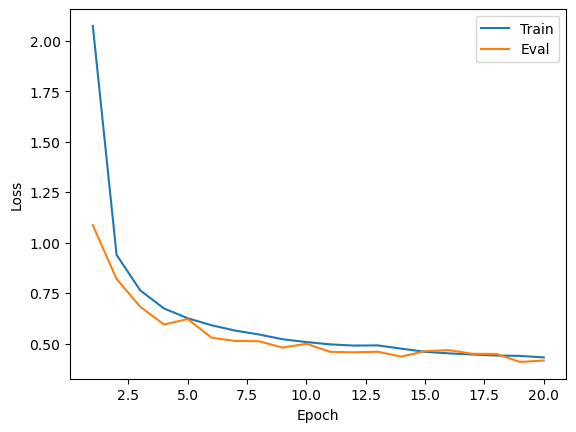

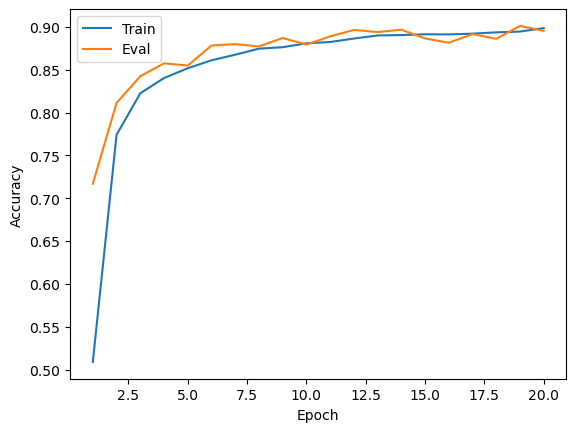

In [70]:
# plot the results
x_axis = np.arange(1, epochs+1)
plt.plot(x_axis, losses, label="Train")
plt.plot(x_axis, losses_eval, label="Eval")
# plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(x_axis, accs, label="Train")
plt.plot(x_axis, accs_eval, label="Eval")
# plt.yscale("log")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# save the results
np.save("mnist_accs_np.npy", np.array(accs))
np.save("mnist_losses_np.npy", np.array(losses))
np.save("mnist_accs_eval_np.npy", np.array(accs_eval))
np.save("mnist_losses_eval_np.npy", np.array(losses_eval))

PopulationSpikeCountMonitor on Input IF Group
firing rate: 63.240572810173035
spike density: 0.12648114562034607
PlotStateMonitor on Input IF Group for out
PlotStateMonitor on Readout Pool Layer for out


/tmp/ipykernel_2100270/2612496646.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  v.show()


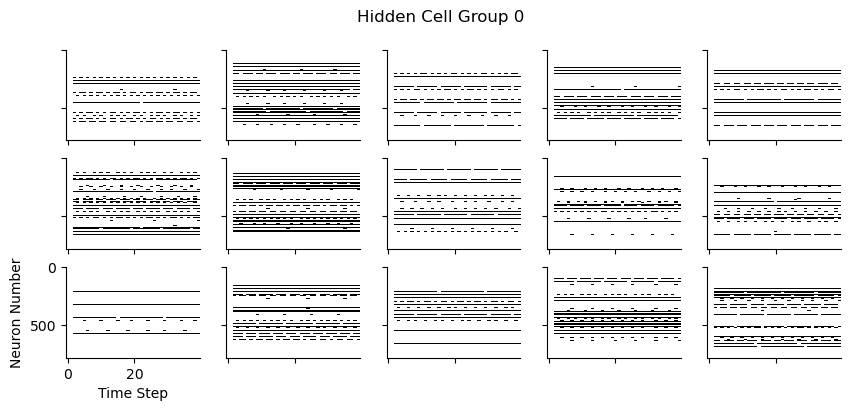

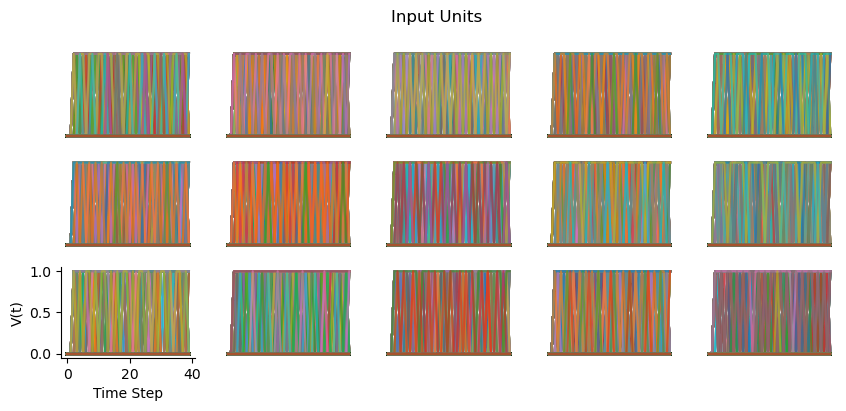

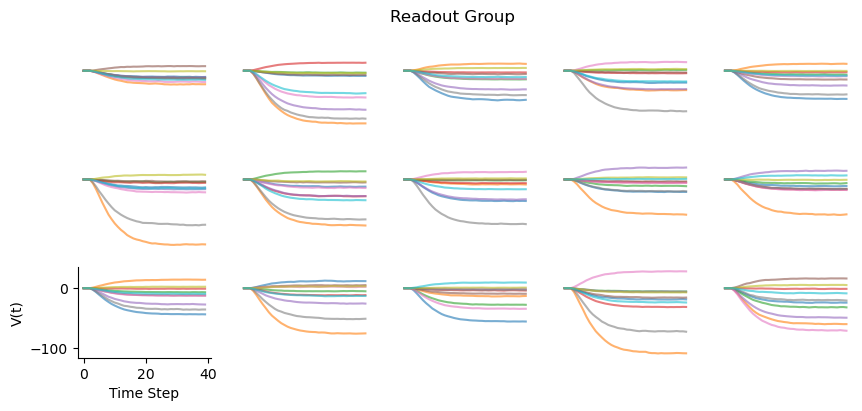

In [56]:
data = rsm.get_monitor_data()
for k, v in data.items():
    print(k)
    if isinstance(v, matplotlib.figure.Figure):
        v.show()
    elif v is None:
        print("None")
    elif "PopulationSpikeCountMonitor" in k:
        print("firing rate:", v.item() / (time_step))
        print("spike density:", v.item())
    else:
        print(v)

In [10]:
# custom loss stack here


class TimeToSpikeCrossEntropy(LossStack):

    """ Loss stack that employs categorical cross entropy. """

    def __init__(self, time_dimension=1, neg_log_likelihood_loss = torch.nn.NLLLoss()):
        super().__init__()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        self.neg_log_likelihood_loss = neg_log_likelihood_loss
        self.time_dim = time_dimension

    def acc_fn(self, log_p_y, target_labels):
        """ Computes classification accuracy from log_p_y and corresponding target labels 

        Args:
            log_p_y: The log softmax output (log p_y_given_x) of the model.
            target_labels: The integer target labels (not one hot encoding).

        Returns:
            Float of mean classification accuracy.
        """
        _, pred_labels = torch.max(log_p_y, dim=self.time_dim)
        a = (pred_labels == target_labels)
        return ((1.0*a.cpu().numpy()).mean())

    def get_metric_names(self):
        return ["acc"]
    
    def get_acc(self, data, target_labels):
        log_py_x = self.log_py_given_x(data)
        return self.acc_fn(log_py_x, target_labels)

    def compute_loss(self, output, targets):
        """ Computes crossentropy loss on softmax defined over sum over time """
        log_p_y = self.log_py_given_x(output)
        loss_value = self.neg_log_likelihood_loss(
            log_p_y, targets)  # compute supervised loss
        acc_val = self.acc_fn(log_p_y, targets)
        self.metrics = [acc_val.item()]
        return loss_value

    def log_py_given_x(self, output):
        su = - torch.argmax(output, dim=self.time_dim).float()
        su[torch.sum(output, dim=self.time_dim) == 0] = -output.shape[self.time_dim]
        su.div_(output.shape[self.time_dim])
        log_p_y = self.log_softmax(su)
        return log_p_y

    def predict(self, output):
        _, pred_labels = torch.max(self.log_py_given_x(output), dim=1)
        return pred_labels

    def __call__(self, output, targets):
        return self.compute_loss(output, targets)

In [61]:
reset_seed()

# model size
n_hidden = 1
input_dim = 784
hidden_dim = 256
output_dim = 10

# neuron parameters
neuron_class = NoisyFastLIFGroup  # FastLIFGroup
neuron_kwargs = dict(
    activation=SigmoidSpike,
    tau_mem_out=0.02,
    tau_syn_out=0.01,
    store_sequences = ["out"],
)  #'noise_std': 0.05}
connection_class = Connection
recurrent = False
connection_kwargs = dict(
    bias=False
)

# readout parameters
readout_class = NoisyFastLIFGroup
readout_kwargs = dict(
    n_readouts=1,
    tau_mem_out=0.02,
    tau_syn_out=0.01,
    store_sequences = ["out"],
)

# initialize weights
sigma_u = 1.0
nu = 10
time_step = 2e-3

# optimizer parameters
lr = 5e-3
optimizer_class = SMORMS3  # torch.optim.Adam # SMORMS3

# regularization parameters
lowerBoundL2Strength = 0.0
lowerBoundL2Threshold = 0.0
upperBoundL2Strength = 0.0  # 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# make the model
rsm = RecurrentSpikingModel(
    device=device,
)

# make the initializers
initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u,
    nu=nu,
    time_step=time_step,
)

# make the regularizers
regs = []
if lowerBoundL2Strength > 0:
    regLB = LowerBoundL2(
        lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
    )
    regs.append(regLB)
if upperBoundL2Strength > 0:
    regUB = UpperBoundL2(upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1)
    regs.append(regUB)

# make the groups and connections
input_group = prev = rsm.add_group(
    FastIFGroup(
    # InputGroup(
        input_dim, 
        name="Input IF Group",
        **neuron_kwargs,
    ))
for i in range(n_hidden):
    new = Layer(
        name=f"Hidden Cell Group {i+1}",
        model=rsm,
        size=hidden_dim,
        input_group=prev,
        recurrent=recurrent,
        regs=regs,
        connection_class=connection_class,
        neuron_class=neuron_class,
        neuron_kwargs=neuron_kwargs,
        connection_kwargs=connection_kwargs,
    )
    initializer.initialize(new)
    prev = new.output_group

output_layer = new = Layer(
    name="Readout Pool Layer",
    model=rsm,
    size=output_dim * readout_kwargs["n_readouts"],
    input_group=prev,
    recurrent=False,
    regs=regs,
    connection_class=connection_class,
    neuron_class=readout_class,
    neuron_kwargs=readout_kwargs,
    connection_kwargs=connection_kwargs,
)
initializer.initialize(new)
prev = new.output_group

# make the monitors
for i in range(n_hidden):
    # rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[1+i], per_example=True))
    rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[1 + i], avg=True))
    rsm.add_monitor(
        PlotStateMonitor(
            rsm.groups[1 + i],
            "out",
            plot_fn=plot_spikes,
            title=f"Hidden Cell Group {i+1}",
        )
    )
    rsm.add_monitor(
        PlotStateMonitor(
            rsm.groups[1 + i],
            "mem",
            plot_fn=plot_traces,
            title=f"Hidden Cell Group {i+1}",
        )
    )
    # rsm.add_monitor(MeanVarianceMonitor(rsm.groups[1 + i], "out", dim=(0, 1)))
rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[0], avg=True))
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[0],
        "out",
        plot_fn=plot_spikes,
        title=f"Hidden Cell Group {0}",
    )
)
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[0], "out", plot_fn=plot_traces, title="Input Units"
    )
)
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[-1], "out", plot_fn=plot_spikes, title="Readout Group"
    )
)

#loss_stack = SumOverTimeCrossEntropy(neg_log_likelihood_loss = torch.nn.NLLLoss(reduction='none'))
loss_stack = TimeToSpikeCrossEntropy(neg_log_likelihood_loss = torch.nn.NLLLoss(reduction='none'))

generator = StandardGenerator()
generator.configure(
    batch_size_train, 100, 784, time_step, device, torch.float32)

rsm.configure(
    input_group,
    prev,
    optimizer=optimizer_class,
    optimizer_kwargs={"lr": lr},
    time_step=time_step,
    generator=generator,
    loss_stack=loss_stack,
)

rsm.summary()


# Model summary

## Groups
Input IF Group, (784,)
Hidden Cell Group 1, (256,)
Readout Pool Layer, (10,)

## Connections
Connection(
  (src): FastIFGroup() Input IF Group
  (dst): NoisyFastLIFGroup() Hidden Cell Group 1
  (op): Linear(in_features=784, out_features=256, bias=False)
) 
Connection(
  (src): NoisyFastLIFGroup() Hidden Cell Group 1
  (dst): NoisyFastLIFGroup() Readout Pool Layer
  (op): Linear(in_features=256, out_features=10, bias=False)
) 

## Trainable Parameters
Total number of trainable parameters: 203264
Number of parameter objects: 2


In [62]:
# run some noise perturbation training

reset_seed()

epochs = 10
repeat_input = 40
learning_rate = 5.0
sigma = 100.0

losses = []
accs = []
losses_eval = []
accs_eval = []

for c in rsm.connections:
    c.op.weight.data *= 0.0

with torch.no_grad():

    for e in range(epochs):

        loss, acc = train_epoch_np_w_optimizer(rsm, train_loader, repeat_input, sigma, device)
        #loss, acc = train_epoch_np(rsm, train_loader, repeat_input, sigma, learning_rate, device)

        losses.append(loss)
        accs.append(acc)

        eloss, eacc = evaluate(rsm, test_loader, repeat_input, device)

        losses_eval.append(eloss)
        accs_eval.append(eacc)

        print(
            f"Epoch {e+1}/{epochs} - Train Loss: {loss:.5f} - Train ACC: {acc:.5f} - Eval Loss: {eloss:.5f} - Eval ACC: {eacc:.5f}"
        )

Epoch 1/10 - Train Loss: 2.08099 - Train ACC: 0.38706 - Eval Loss: 1.94726 - Eval ACC: 0.55985
Epoch 2/10 - Train Loss: 1.87978 - Train ACC: 0.64119 - Eval Loss: 1.87301 - Eval ACC: 0.66916
Epoch 3/10 - Train Loss: 1.83156 - Train ACC: 0.68942 - Eval Loss: 1.81508 - Eval ACC: 0.70411
Epoch 4/10 - Train Loss: 1.81647 - Train ACC: 0.69858 - Eval Loss: 1.80779 - Eval ACC: 0.71074
Epoch 5/10 - Train Loss: 1.80710 - Train ACC: 0.70465 - Eval Loss: 1.80446 - Eval ACC: 0.70681
Epoch 6/10 - Train Loss: 1.80960 - Train ACC: 0.69863 - Eval Loss: 1.80385 - Eval ACC: 0.70688
Epoch 7/10 - Train Loss: 1.79957 - Train ACC: 0.70708 - Eval Loss: 1.78911 - Eval ACC: 0.71519
Epoch 8/10 - Train Loss: 1.79599 - Train ACC: 0.70891 - Eval Loss: 1.78536 - Eval ACC: 0.71751
Epoch 9/10 - Train Loss: 1.79063 - Train ACC: 0.71088 - Eval Loss: 1.78521 - Eval ACC: 0.71843
Epoch 10/10 - Train Loss: 1.79051 - Train ACC: 0.71185 - Eval Loss: 1.78602 - Eval ACC: 0.72044


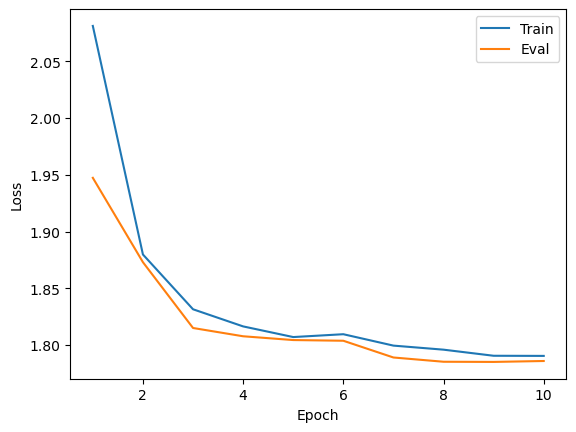

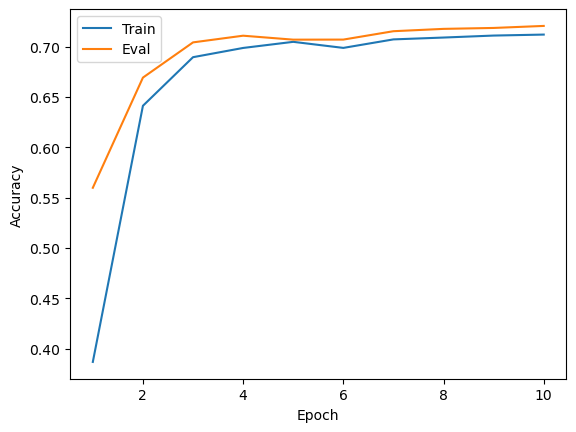

In [63]:
# plot the results
x_axis = np.arange(1, epochs+1)
plt.plot(x_axis, losses, label="Train")
plt.plot(x_axis, losses_eval, label="Eval")
# plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(x_axis, accs, label="Train")
plt.plot(x_axis, accs_eval, label="Eval")
# plt.yscale("log")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# save the results
np.save("mnist_accs_sur.npy", np.array(accs))
np.save("mnist_losses_sur.npy", np.array(losses))
np.save("mnist_accs_eval_sur.npy", np.array(accs_eval))
np.save("mnist_losses_eval_sur.npy", np.array(losses_eval))

PopulationSpikeCountMonitor on Hidden Cell Group 1
firing rate: 180.8965504169464
spike density: 0.3617931008338928
PlotStateMonitor on Hidden Cell Group 1 for out
PlotStateMonitor on Hidden Cell Group 1 for mem
PopulationSpikeCountMonitor on Input IF Group
firing rate: 60.93304604291916
spike density: 0.12186609208583832
PlotStateMonitor on Input IF Group for out
PlotStateMonitor on Readout Pool Layer for out


/tmp/ipykernel_2145640/2612496646.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  v.show()


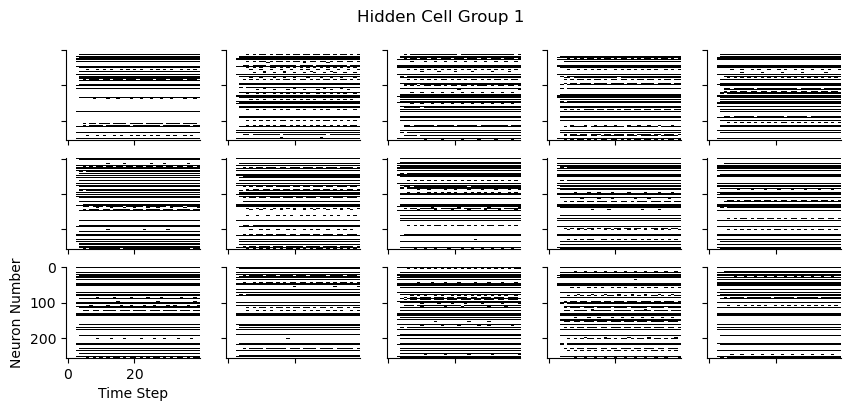

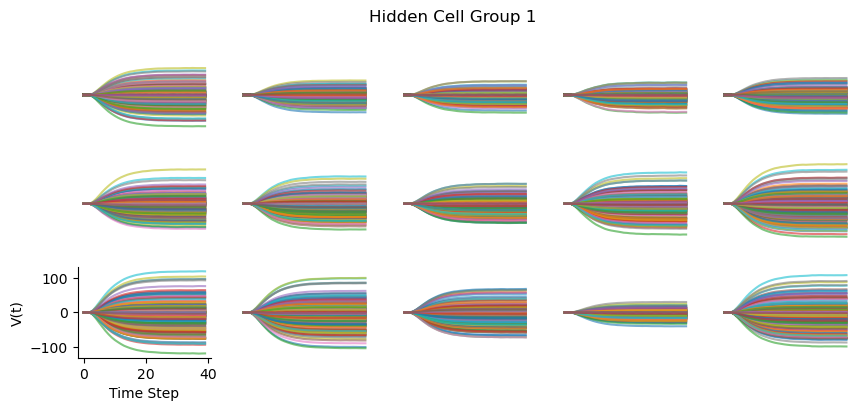

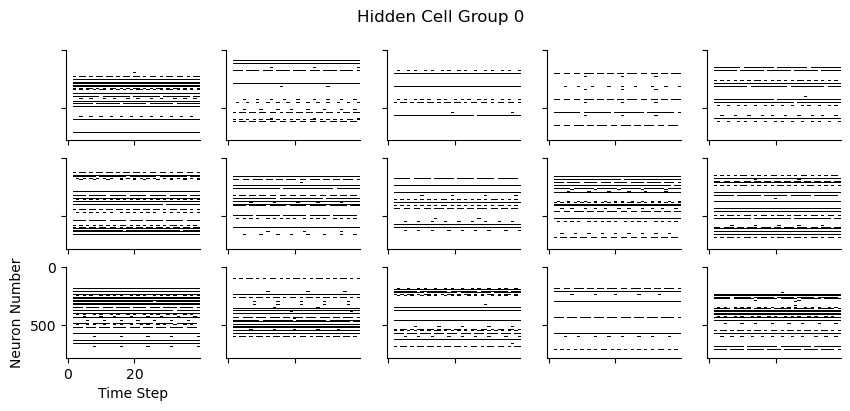

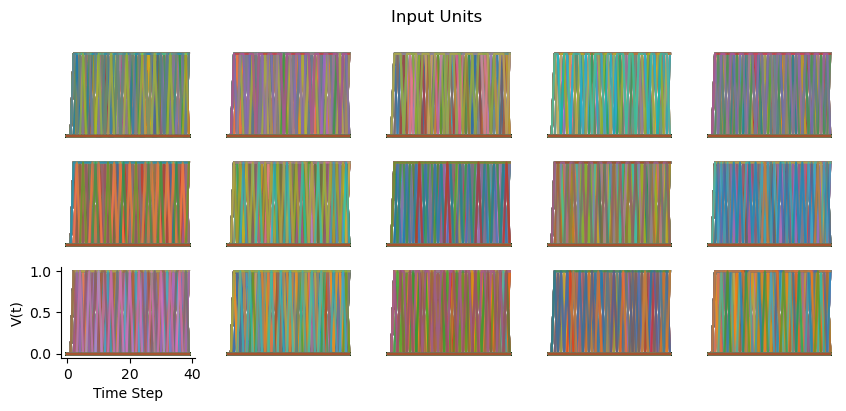

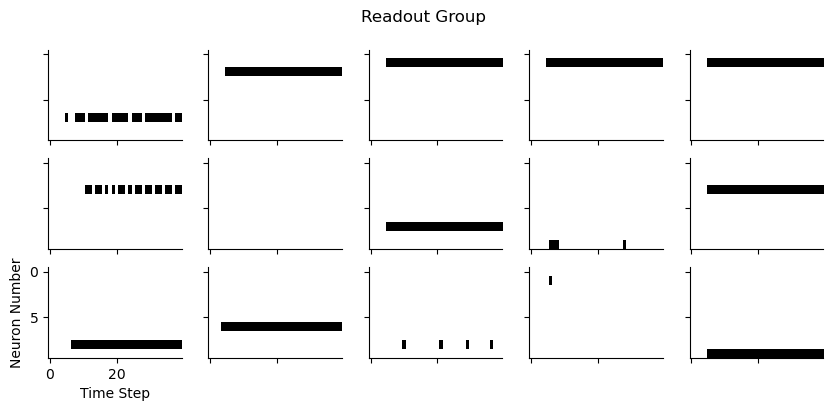

In [64]:
data = rsm.get_monitor_data()
for k, v in data.items():
    print(k)
    if isinstance(v, matplotlib.figure.Figure):
        v.show()
    elif v is None:
        print("None")
    elif "PopulationSpikeCountMonitor" in k:
        print("firing rate:", v.item() / (time_step))
        print("spike density:", v.item())
    else:
        print(v)

In [56]:
reset_seed()

# model size
n_hidden = 1
input_dim = 784
hidden_dim = 256
output_dim = 10

# neuron parameters
neuron_class = NoisyFastLIFGroup  # FastLIFGroup
neuron_kwargs = dict(
    activation=SigmoidSpike,
    tau_mem_out=0.02,
    tau_syn_out=0.01,
    store_sequences = ["out"],
)  #'noise_std': 0.05}
connection_class = Connection
recurrent = True
connection_kwargs = dict(
    bias=False
)

# readout parameters
readout_class = NoisyFastLIFGroup
readout_kwargs = dict(
    n_readouts=1,
    tau_mem_out=0.02,
    tau_syn_out=0.01,
    store_sequences = ["out"],
)

# initialize weights
sigma_u = 1.0
nu = 10
time_step = 2e-3

# optimizer parameters
lr = 5e-3
optimizer_class = SMORMS3  # torch.optim.Adam # SMORMS3

# regularization parameters
lowerBoundL2Strength = 0.0
lowerBoundL2Threshold = 0.0
upperBoundL2Strength = 0.0  # 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# make the model
rsm = RecurrentSpikingModel(
    device=device,
)

# make the initializers
initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u,
    nu=nu,
    time_step=time_step,
)

# make the regularizers
regs = []
if lowerBoundL2Strength > 0:
    regLB = LowerBoundL2(
        lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
    )
    regs.append(regLB)
if upperBoundL2Strength > 0:
    regUB = UpperBoundL2(upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1)
    regs.append(regUB)

# make the groups and connections
input_group = prev = rsm.add_group(
    FastIFGroup(
    # InputGroup(
        input_dim, 
        name="Input IF Group",
        **neuron_kwargs,
    ))
if recurrent:
    c = connection_class(prev, prev, **connection_kwargs)
    c.op.weight.data *= 0.0
    rsm.add_connection(c)
for i in range(n_hidden):
    new = Layer(
        name=f"Hidden Cell Group {i+1}",
        model=rsm,
        size=hidden_dim,
        input_group=prev,
        recurrent=recurrent,
        regs=regs,
        connection_class=connection_class,
        neuron_class=neuron_class,
        neuron_kwargs=neuron_kwargs,
        connection_kwargs=connection_kwargs,
    )
    initializer.initialize(new)
    prev = new.output_group

output_layer = new = Layer(
    name="Readout Pool Layer",
    model=rsm,
    size=output_dim * readout_kwargs["n_readouts"],
    input_group=prev,
    recurrent=False,
    regs=regs,
    connection_class=connection_class,
    neuron_class=readout_class,
    neuron_kwargs=readout_kwargs,
    connection_kwargs=connection_kwargs,
)
initializer.initialize(new)
prev = new.output_group

# make the monitors
for i in range(n_hidden):
    # rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[1+i], per_example=True))
    rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[1 + i], avg=True))
    rsm.add_monitor(
        PlotStateMonitor(
            rsm.groups[1 + i],
            "out",
            plot_fn=plot_spikes,
            title=f"Hidden Cell Group {i+1}",
        )
    )
    rsm.add_monitor(
        PlotStateMonitor(
            rsm.groups[1 + i],
            "mem",
            plot_fn=plot_traces,
            title=f"Hidden Cell Group {i+1}",
        )
    )
    # rsm.add_monitor(MeanVarianceMonitor(rsm.groups[1 + i], "out", dim=(0, 1)))
rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[0], avg=True))
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[0],
        "out",
        plot_fn=plot_spikes,
        title=f"Hidden Cell Group {0}",
    )
)
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[0], "out", plot_fn=plot_traces, title="Input Units"
    )
)
rsm.add_monitor(
    PlotStateMonitor(
        rsm.groups[-1], "out", plot_fn=plot_spikes, title="Readout Group"
    )
)

#loss_stack = SumOverTimeCrossEntropy(neg_log_likelihood_loss = torch.nn.NLLLoss(reduction='none'))
loss_stack = TimeToSpikeCrossEntropy(neg_log_likelihood_loss = torch.nn.NLLLoss(reduction='none'))

generator = StandardGenerator()
generator.configure(
    batch_size_train, 100, 784, time_step, device, torch.float32)

rsm.configure(
    input_group,
    prev,
    optimizer=optimizer_class,
    optimizer_kwargs={"lr": lr},
    time_step=time_step,
    generator=generator,
    loss_stack=loss_stack,
)

rsm.summary()

for c in rsm.connections:
    if c.recurrent:
        c.op.weight.data *= 0.0


# Model summary

## Groups
Input IF Group, (784,)
Hidden Cell Group 1, (256,)
Readout Pool Layer, (10,)

## Connections
Connection(
  (src): FastIFGroup() Input IF Group
  (dst): FastIFGroup() Input IF Group
  (op): Linear(in_features=784, out_features=784, bias=False)
) 
Connection(
  (src): FastIFGroup() Input IF Group
  (dst): NoisyFastLIFGroup() Hidden Cell Group 1
  (op): Linear(in_features=784, out_features=256, bias=False)
) 
Connection(
  (src): NoisyFastLIFGroup() Hidden Cell Group 1
  (dst): NoisyFastLIFGroup() Hidden Cell Group 1
  (op): Linear(in_features=256, out_features=256, bias=False)
) 
Connection(
  (src): NoisyFastLIFGroup() Hidden Cell Group 1
  (dst): NoisyFastLIFGroup() Readout Pool Layer
  (op): Linear(in_features=256, out_features=10, bias=False)
) 

## Trainable Parameters
Total number of trainable parameters: 883456
Number of parameter objects: 4


In [57]:
# define a noise pertubation training function
def train_epoch_np(model, train_loader, repeat_input, sigma, learning_rate, device):
    """Train the model on the training set for a single epoch with surrogate gradients.

    Args:
        model: The model to evaluate.
        train_loader: The training set loader.81112
        repeat_input: The number of times to repeat the input.
        sigma: The noise level.
        learning_rate: The learning rate.
        device: The device to use.

    Returns:
        The average loss and accuracy.
    """

    model.train()
    losses = []
    accs = []
    batch = 0

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        N = data.shape[0]

        # do pass without noise
        for g in model.groups[1:]:
            g.set_noise_flag(False)
        model.reset_state(N)

        for i in range(repeat_input):
            y_no_noise = model(data / model.time_step)

        loss_no_noise = model.loss_stack.compute_loss(y_no_noise, target)
        acc_no_noise = model.loss_stack.get_acc(y_no_noise, target)

        losses.append(torch.mean(loss_no_noise).item())
        accs.append(acc_no_noise.item())

        # do pass with noise
        for g in model.groups[1:]:
            g.set_noise_flag(True, sigma=sigma)
        model.reset_state(N)

        for i in range(repeat_input):
            y_w_noise = model(data / model.time_step)

        loss_w_noise = model.loss_stack.compute_loss(y_w_noise, target)

        delta_loss = loss_w_noise - loss_no_noise

        for c in model.connections:
            if c.recurrent:
                beta = 0.1
                rates = c.src.get_out_sequence().mean(axis=1)
                corrs = 0.01* (1/N)*((rates.transpose(0,1) - beta)
                @ rates)
                corrs = corrs - torch.diag(torch.diag(corrs))
                c.op.weight.data -= learning_rate * corrs
            else:
                # Averaging over batch, computing traditional NP update
                norm_noise = normalize_noise(c.dst.get_noise())
                delta_w = (
                    -(1 / N) 
                    * (delta_loss[:, None] * norm_noise).transpose(0, 1)
                    @ torch.mean(c.src.get_out_sequence(), axis=1)
                )

                c.op.weight.data += learning_rate * delta_w
                if c.op.bias is not None:
                    delta_b = - (delta_loss[:, None] * norm_noise).mean(axis=0)
                    c.op.bias.data += learning_rate * delta_b
            
        batch += 1

    for g in model.groups[1:]:
        g.set_noise_flag(False)

    avg_loss = torch.mean(torch.tensor(losses))
    avg_acc = torch.mean(torch.tensor(accs))

    return avg_loss, avg_acc


# define a noise pertubation training function with optimizer
def train_epoch_np_w_optimizer(model, train_loader, repeat_input, sigma, device):
    """Train the model on the training set for a single epoch with surrogate gradients.

    Args:
        model: The model to evaluate.
        train_loader: The training set loader.
        repeat_input: The number of times to repeat the input.
        sigma: The noise level.
        device: The device to use.

    Returns:
        The average loss and accuracy.
    """

    model.train()
    losses = []
    accs = []
    batch = 0

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        N = data.shape[0]

        # do pass without noise
        for g in model.groups[1:]:
            g.set_noise_flag(False)
        model.reset_state(N)

        for i in range(repeat_input):
            y_no_noise = model(data / model.time_step)

        loss_no_noise = model.loss_stack.compute_loss(y_no_noise, target)
        acc_no_noise = model.loss_stack.get_acc(y_no_noise, target)

        losses.append(torch.mean(loss_no_noise).item())
        accs.append(acc_no_noise.item())

        # do pass with noise
        for g in model.groups[1:]:
            g.set_noise_flag(True, sigma=sigma)
        model.reset_state(N)

        for i in range(repeat_input):
            y_w_noise = model(data / model.time_step)

        loss_w_noise = model.loss_stack.compute_loss(y_w_noise, target)

        delta_loss = loss_w_noise - loss_no_noise

        model.optimizer_instance.zero_grad()
        for c in model.connections:
            if c.recurrent:
                beta = 0.1 # HACKY
                rates = c.src.get_out_sequence().mean(axis=1)
                corrs = 0.01* (1/N)*((rates.transpose(0,1) - beta)
                @ rates)
                corrs = corrs - torch.diag(torch.diag(corrs))
                c.op.weight.grad = corrs
            else:
                # Averaging over batch, computing traditional NP update
                norm_noise = normalize_noise(c.dst.get_noise())
                grad = (
                    (1 / N)
                    * (delta_loss[:, None] * norm_noise).transpose(0, 1)
                    @ torch.mean(c.src.get_out_sequence(), axis=1)
                )
                c.op.weight.grad = grad
                if c.op.bias is not None:
                    grad = (delta_loss[:, None] * norm_noise).mean(axis=0)
                    c.op.bias.grad = grad
                
        model.optimizer_instance.step()

        batch += 1

    for g in model.groups[1:]:
        g.set_noise_flag(False)

    avg_loss = torch.mean(torch.tensor(losses))
    avg_acc = torch.mean(torch.tensor(accs))

    return avg_loss, avg_acc

In [59]:
# run some noise perturbation training

reset_seed()

epochs = 10
repeat_input = 40
learning_rate = 5.0
sigma = 100.0

losses = []
accs = []
losses_eval = []
accs_eval = []

for c in rsm.connections:
    c.op.weight.data *= 0.0

with torch.no_grad():

    for e in range(epochs):

        loss, acc = train_epoch_np_w_optimizer(rsm, train_loader, repeat_input, sigma, device)
        # loss, acc = train_epoch_np(rsm, train_loader, repeat_input, sigma, learning_rate, device)

        losses.append(loss)
        accs.append(acc)

        eloss, eacc = evaluate(rsm, test_loader, repeat_input, device)

        losses_eval.append(eloss)
        accs_eval.append(eacc)

        print(
            f"Epoch {e+1}/{epochs} - Train Loss: {loss:.5f} - Train ACC: {acc:.5f} - Eval Loss: {eloss:.5f} - Eval ACC: {eacc:.5f}"
        )

Epoch 1/10 - Train Loss: 2.04370 - Train ACC: 0.42358 - Eval Loss: 1.90051 - Eval ACC: 0.60362
Epoch 2/10 - Train Loss: 1.84830 - Train ACC: 0.62625 - Eval Loss: 1.83199 - Eval ACC: 0.63778
Epoch 3/10 - Train Loss: 1.82193 - Train ACC: 0.63441 - Eval Loss: 1.81683 - Eval ACC: 0.60917


KeyboardInterrupt: 

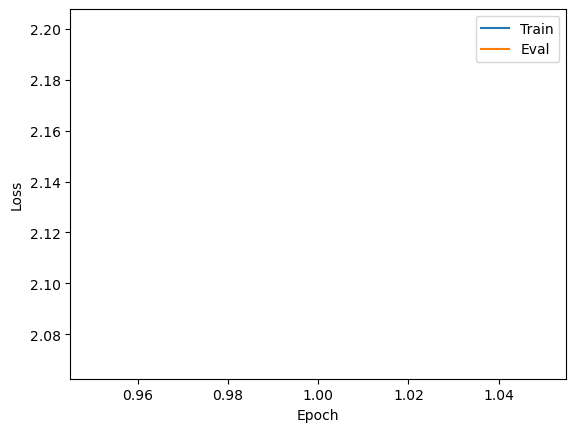

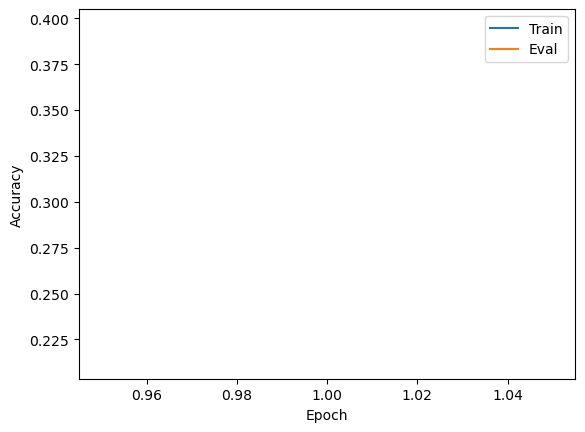

In [ ]:
# plot the results
x_axis = np.arange(1, epochs+1)
plt.plot(x_axis, losses, label="Train")
plt.plot(x_axis, losses_eval, label="Eval")
# plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(x_axis, accs, label="Train")
plt.plot(x_axis, accs_eval, label="Eval")
# plt.yscale("log")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# save the results
np.save("mnist_accs_sur.npy", np.array(accs))
np.save("mnist_losses_sur.npy", np.array(losses))
np.save("mnist_accs_eval_sur.npy", np.array(accs_eval))
np.save("mnist_losses_eval_sur.npy", np.array(losses_eval))

PopulationSpikeCountMonitor on Hidden Cell Group 1
firing rate: 66.7995736002922
spike density: 0.1335991472005844
PlotStateMonitor on Hidden Cell Group 1 for out
PlotStateMonitor on Hidden Cell Group 1 for mem
PopulationSpikeCountMonitor on Input IF Group
firing rate: 62.91401386260986
spike density: 0.12582802772521973
PlotStateMonitor on Input IF Group for out
PlotStateMonitor on Readout Pool Layer for out


/tmp/ipykernel_2174801/2612496646.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  v.show()


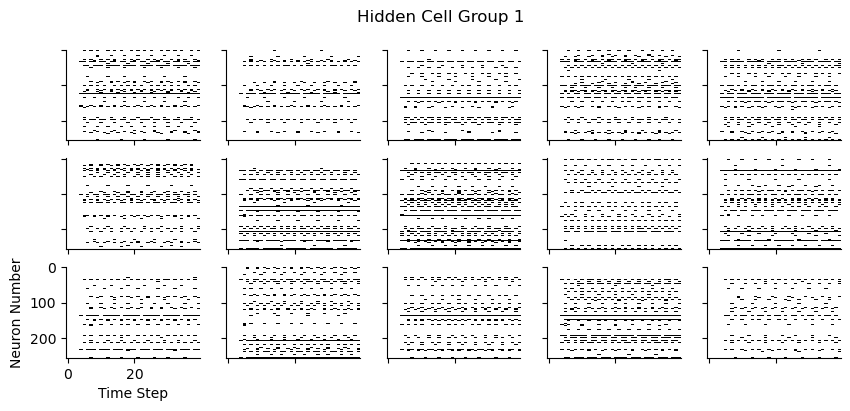

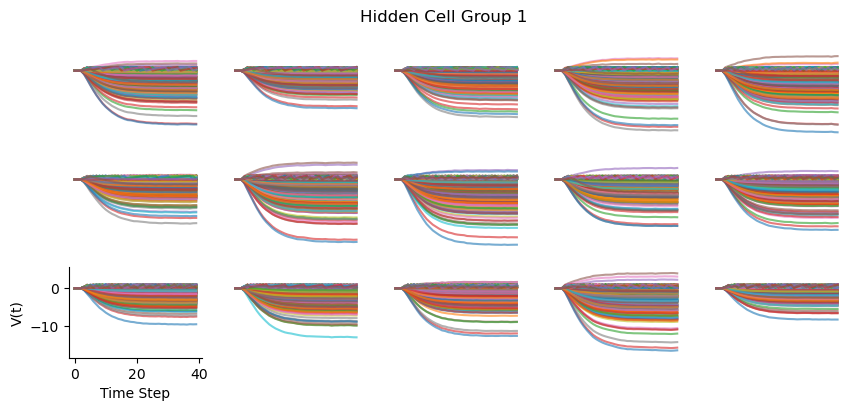

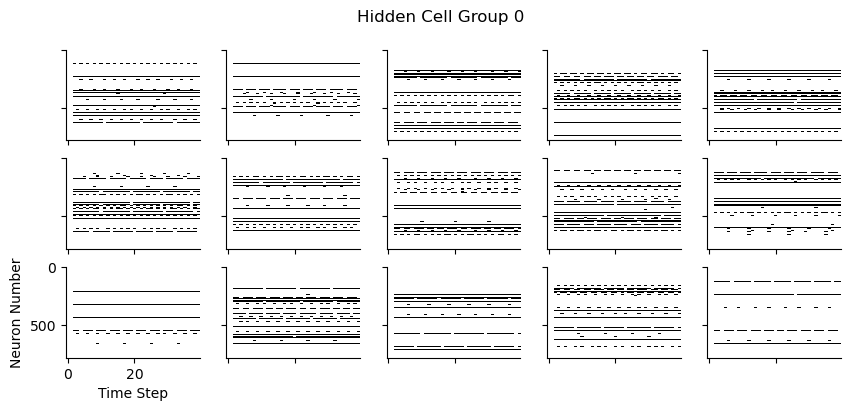

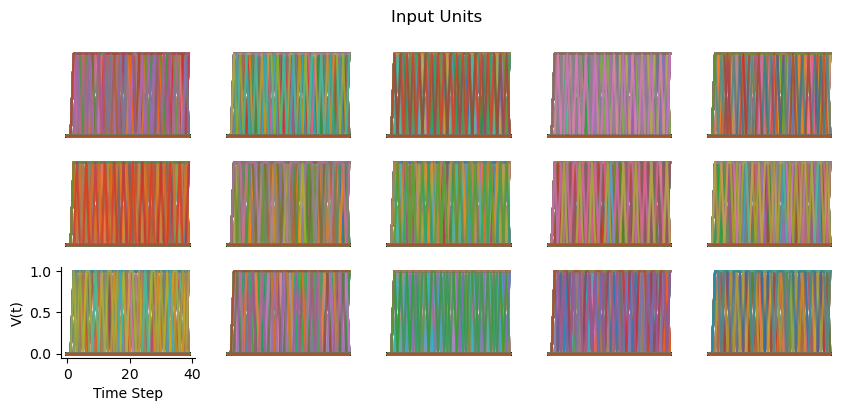

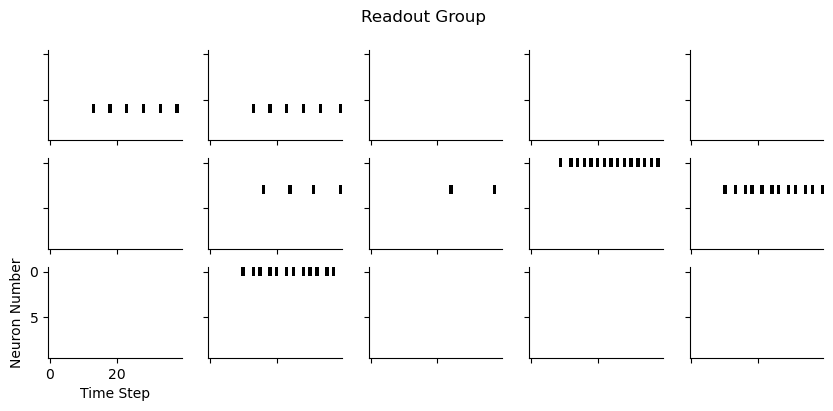

In [ ]:
data = rsm.get_monitor_data()
for k, v in data.items():
    print(k)
    if isinstance(v, matplotlib.figure.Figure):
        v.show()
    elif v is None:
        print("None")
    elif "PopulationSpikeCountMonitor" in k:
        print("firing rate:", v.item() / (time_step))
        print("spike density:", v.item())
    else:
        print(v)